### An implementation of Time Series Classification on primate splice-junction data. The goal of this project is to classify intron-exon and exon-intron boundaries.
# Data Cleanup
First, we import all libraries used, and the data:

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dtw import dtw
from random import choice
import os.path
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.stats import mode

df = pd.read_csv('splice.data', names = ['Class', 'Name', 'Sequence'])
df.head()

,Class,Name,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


Since the original data may have inconsistent spacing, we will strip any leading or tailing whitespace from each entry.

In [2]:
df['Class'] = df['Class'].str.strip()
df['Name'] = df['Name'].str.strip()
df['Sequence'] = df['Sequence'].str.strip()

For the purposes of our initial model, we will remove any instances in the "N" or Neither class. This will leave only the EI and IE class for analysis.

In [3]:
df = df[df.Class != 'N']
df['Class'].value_counts()

IE    768
EI    767
Name: Class, dtype: int64

There is one entry that has incomplete data; it can be removed.

In [4]:
df[df.Name == 'HUMALPI1-DONOR-42'].iloc[0, 2]
df = df[df.Name != 'HUMALPI1-DONOR-42']

'CACACAGGGCACCCCCTCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

The "Name" feature is unnecessary for the procedure, and can be dropped.

In [5]:
df = df.drop('Name', axis=1)
df.head()

,Class,Sequence
0,EI,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


Mapping EI and IE to 0 and 1 respectively, makes it easier for our classifier later on.

In [6]:
df['Class'] = df['Class'].map({'EI': 0, 'IE': 1})
df.head()
df.tail()

,Class,Sequence
0,0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,0,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,0,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,0,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,0,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


,Class,Sequence
1530,1,AGCCTGGGCTGACCCCACGTCTGGCCACAGGCCCGCGTGCTGCCCC...
1531,1,CTGTCCTGTGGGTTCCTCTCACCCCCTCAGGCTGCTGGTCGTCTAC...
1532,1,ATGTTTAAACCTCGCGTTTCCTCCCCGCAGCTCTTGGGCAATGTGC...
1533,1,CTGTCCTGTGGGTTCCTCTCACCCTCTCAGGTTGCTGGTCGTCTAC...
1534,1,CATATGTATCTTTTTACCTTTTCCCAACAGCTCCTGGGCAACGTGC...


It is necessary to encode our nucleotides into numbers so their pattern and ordering can be analyzed. The bases will be encoded into 1, 2, 3, and 4 in alphabetical order. The ambiguous nucleotides, N, D, S, and R will be pseudorandomly chosen, based on the possible nucleotides it could be.

In [7]:
def translateSequence(sequence):
    baseDict = {'A':'1', 'C':'2', 'G':'3', 'T':'4', 'N':choice(['1', '2', '3', '4']),
               'D':choice(['1', '3', '4']), 'S':choice(['2', '3']), 'R':choice(['1', '3'])}
    newSequence = ''
    for base in sequence:
        newSequence += baseDict[base] 
    return newSequence

df['Sequence'] = [translateSequence(sequence) for sequence in df['Sequence']]
df.head()

,Class,Sequence
0,0,2213243214212133133221323132133424344221133322...
1,0,1312223223331332331331224321333431322221223222...
2,0,3133431133123422442222133132233431311323213423...
3,0,3332432344324334212144224332133414333323333244...
4,0,3242132222213342122213311243123431343422221422...


Finally, we will separate each columns into their own individual Numpy arrays. Note that each sequence of numbers is being split, forming a matrix. Each row in this matrix will contain a sequence that has been encoded into numbers.

In [8]:
y = np.asarray(df['Class'])
np.shape(y)
X = np.asarray([list(map(int, sequence)) for sequence in df['Sequence']])
X
np.shape(X)

(1534,)

array([[2, 2, 1, ..., 2, 4, 3],
       [1, 3, 1, ..., 2, 3, 2],
       [3, 1, 3, ..., 1, 4, 3],
       ...,
       [1, 4, 3, ..., 2, 4, 3],
       [2, 4, 3, ..., 3, 1, 3],
       [2, 1, 4, ..., 2, 4, 3]])

(1534, 60)

# Dynamic Time Warping

Now we're ready for the dynamic time warping procedure. We iterate through all sequences, taking the euclidean distance and calculating the dissimilarity score:

NOTE: This procedure took approximately 10 hours to run on my machine. Using my pre-generated dissimilarity matrix is preferable.

In [9]:
if os.path.exists("matrix.csv"):
    dissimMatrix = np.asarray(pd.read_csv("matrix.csv", index_col=0))
else:
    dissimMatrix = []
    for i, seq1 in enumerate(X):
        dissimMatrix.append([])
        for seq2 in X:
            euclideanDist = lambda seq1, seq2: np.abs(seq1 - seq2)
            warpScore = dtw(seq1, seq2, dist=euclideanDist)
            dissimMatrix[i].append(warpScore[0])
    pd.DataFrame(data=dissimMatrix).to_csv("matrix.csv")

# PCA

Principal Component Analysis allows us to reduce the dimensionality of this high dimensional data-set. This allows us to plot the data in 2 or 3 dimensions.

In [10]:
reducedMatrix = PCA(n_components=3).fit_transform(dissimMatrix)

<IPython.core.display.Javascript object>


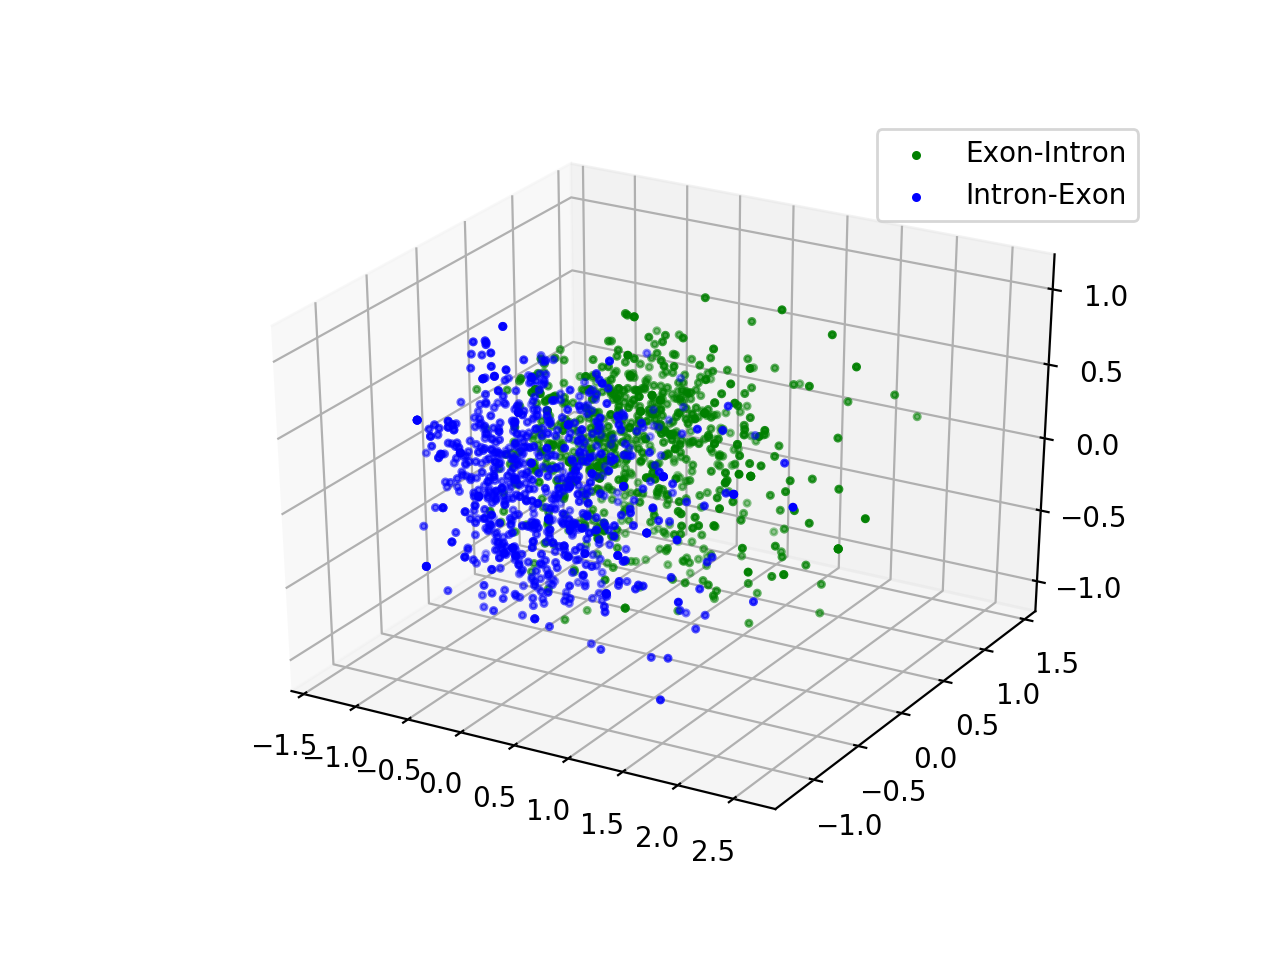

In [11]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reducedMatrix[:766, 0], reducedMatrix[:766, 1], reducedMatrix[:766, 2], marker='.', c='green')
ax.scatter(reducedMatrix[766:, 0], reducedMatrix[766:, 1], reducedMatrix[766:, 2], marker='.', c='blue')
ax.legend(['Exon-Intron', 'Intron-Exon'])
plt.show()

# K Nearest Neighbors

Finally, our model is ready to be validated/tested. First, we need to split the dataset, using Stratified K-Folds.

In [12]:
def createMatrix(values, train_index, dissimMatrix):
    matrix = []
    for c, i in enumerate(values):
        matrix.append([])
        for j in train_index:
            matrix[c].append(dissimMatrix[i][j])
    return matrix

def splitData(X, y, dissimMatrix):
    skf = StratifiedKFold(n_splits=5)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in skf.split(X, y):
        X_train.append(createMatrix(train_index, train_index, dissimMatrix))
        X_test.append(createMatrix(test_index, train_index, dissimMatrix))
        y_train.append(y[train_index])
        y_test.append(y[test_index])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(X, y, dissimMatrix)

Now, we make the predictions:

In [13]:
def predictClass(X_train, X_test, y_train, y_test, k):
    y_pred = []
    metric = {'acc':[], 'conf':[], 'prec':[], 'recall':[], 'f1':[]}
    model = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    for i, fold in enumerate(X_test):
        y_pred.append([])
        model = model.fit(X_train[i], y_train[i])
        y_pred[i] = model.predict(fold)
        pair = y_test[i], y_pred[i]
        metric['acc'].append(accuracy_score(*pair))
        metric['conf'].append(confusion_matrix(*pair).ravel())
        metric['prec'].append(precision_score(*pair))
        metric['recall'].append(recall_score(*pair))
        metric['f1'].append(f1_score(*pair))
    return metric
kMin, kMax = 1, 3
kArr = list(range(kMin, kMax + 1)) + [11, 14]
results = np.asarray([predictClass(X_train, X_test, y_train, y_test, k) for k in kArr])

And output the results:

In [14]:
for i, k in enumerate(results):
    table = pd.DataFrame(np.asarray(list(k.values())).T, index=range(1,len(X_test) + 1),
                         columns=['Accuracy', 'Confusion Matrix', 'Precision', 'Recall', 'F1'])
    table[['TN', 'FP', 'FN', 'TP']] = pd.DataFrame(table['Confusion Matrix'].values.tolist(), index=table.index)
    table = table.drop('Confusion Matrix', axis=1)
    means = pd.DataFrame(table.iloc[:,0:4].mean(), columns=['Average']).transpose()
    table = table.append(means, sort=False)
    print('\t\t\t{}-NN'.format(kArr[i]))
    table
    print()

			1-NN


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.821429,0.832215,0.805195,0.818482,129.0,25.0,30.0,124.0
2,0.798046,0.828571,0.753247,0.789116,129.0,24.0,38.0,116.0
3,0.814332,0.848921,0.766234,0.805461,132.0,21.0,36.0,118.0
4,0.77451,0.823077,0.699346,0.756184,130.0,23.0,46.0,107.0
5,0.833333,0.849315,0.810458,0.829431,131.0,22.0,29.0,124.0
Average,0.80833,0.83642,0.766896,0.799735,NaN,NaN,NaN,NaN



			2-NN


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.798701,0.933962,0.642857,0.761538,147.0,7.0,55.0,99.0
2,0.775244,0.882883,0.636364,0.739623,140.0,13.0,56.0,98.0
3,0.781759,0.878261,0.655844,0.750929,139.0,14.0,53.0,101.0
4,0.748366,0.931818,0.535948,0.680498,147.0,6.0,71.0,82.0
5,0.830065,0.917355,0.72549,0.810219,143.0,10.0,42.0,111.0
Average,0.786827,0.908856,0.639301,0.748561,NaN,NaN,NaN,NaN



			3-NN


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.847403,0.902256,0.779221,0.836237,141.0,13.0,34.0,120.0
2,0.814332,0.843972,0.772727,0.80678,131.0,22.0,35.0,119.0
3,0.85342,0.856209,0.850649,0.85342,131.0,22.0,23.0,131.0
4,0.820261,0.860294,0.764706,0.809689,134.0,19.0,36.0,117.0
5,0.866013,0.873333,0.856209,0.864686,134.0,19.0,22.0,131.0
Average,0.840286,0.867213,0.804702,0.834162,NaN,NaN,NaN,NaN



			11-NN


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.896104,0.886076,0.909091,0.897436,136.0,18.0,14.0,140.0
2,0.863192,0.85,0.883117,0.866242,129.0,24.0,18.0,136.0
3,0.908795,0.879518,0.948052,0.9125,133.0,20.0,8.0,146.0
4,0.843137,0.822086,0.875817,0.848101,124.0,29.0,19.0,134.0
5,0.895425,0.853801,0.954248,0.901235,128.0,25.0,7.0,146.0
Average,0.881331,0.858296,0.914065,0.885103,NaN,NaN,NaN,NaN



			14-NN


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.892857,0.900662,0.883117,0.891803,139.0,15.0,18.0,136.0
2,0.869707,0.865385,0.876623,0.870968,132.0,21.0,19.0,135.0
3,0.908795,0.884146,0.941558,0.91195,134.0,19.0,9.0,145.0
4,0.859477,0.857143,0.862745,0.859935,131.0,22.0,21.0,132.0
5,0.895425,0.866667,0.934641,0.899371,131.0,22.0,10.0,143.0
Average,0.885252,0.874801,0.899737,0.886805,NaN,NaN,NaN,NaN


In this context:
* A True Negative means that an EI was correctly identified as EI
* A False Positive means that an EI was incorrectly identified as IE
* A False Negative means that an IE was incorrectly identified as EI
* A True Positive means that an IE was correctly identified as IE